In [76]:
import pickle
import os
from os.path import dirname, abspath
import glob
import numpy as np
from plotly.subplots import make_subplots

os.chdir('/BS/mlcysec2/work/adaptive-hierarchical-certification/')

experiment_name = 'exp_best_threshold_function'
dicts = glob.glob(f'cityscapes_logs/slurm_logs/{experiment_name}/frankfurt_000000_020321.pkl')

overall_d = dict()
for im_dict in dicts:
    d = pickle.load(open(im_dict, 'rb'))
    for im_name_k in d.keys():
        overall_d[im_name_k] = d[im_name_k]
graph_dict = {} # should have (n, n0, th_func, i) as keys, values: sum
for name, name_dict in overall_d.items():
    for k in name_dict.keys():
        if k not in graph_dict:
            graph_dict[k] = {'num_pixels':0, 
                            'certified_pixels':0, 
                            'c_info_gain':0, 
                            'certified_pos':0, 
                            'boundary_pixels':0, 
                            'nonboundary_pixels':0, 
                            'pos_certified_boundary_pixels':0, 
                            'pos_certified_nonboundary_pixels':0,
                            'num_h_pixels':{}, 'pos_h_pixels':{},
                            'ig_per_class_dict': {i:{'ig': np.zeros(19), 'pixels_count': np.zeros(19)} for i in range(4)}}
        graph_dict[k]['num_pixels'] += name_dict[k]['num_pixels']
        graph_dict[k]['certified_pixels'] += name_dict[k]['certified_pixels']
        graph_dict[k]['certified_pos'] += name_dict[k]['certified_pos']
        graph_dict[k]['c_info_gain'] += name_dict[k]['c_info_gain']
        for i in name_dict[k]['ig_per_class_dict'].keys():
            graph_dict[k]['ig_per_class_dict'][i]['ig'] += name_dict[k]['ig_per_class_dict'][i]['ig']
            graph_dict[k]['ig_per_class_dict'][i]['pixels_count'] += name_dict[k]['ig_per_class_dict'][i]['pixels_count']

In [72]:
k = (300, 20, '(0, 0.2, 0.3)', 4)
print(graph_dict[k]['c_info_gain']/graph_dict[k]['num_pixels']/np.log(19))
k = (300, 20, None, 0)
print(graph_dict[k]['c_info_gain']/graph_dict[k]['num_pixels']/np.log(19))

# choose the threshold functions with c_info_gain > SegCertify 
ns = sorted(list(set(np.array(list(graph_dict.keys()))[:, 0])))
n0s = list(set(np.array(list(graph_dict.keys()))[:, 1]))
fs_ = list(set(np.array(list(graph_dict.keys()))[:, 2]))
fs = fs_
n0 = 20


compare_dict = dict() # th_func: (adaptive, segcertify)
fs_.remove(None)
for th in fs_:
    c_info_gain_adaptive = 0
    num_pixels_adaptive = 0
    c_info_gain_segcertify = 0
    num_pixels_segcertify = 0
    for n in ns:
        c_info_gain_adaptive += graph_dict[(n, n0, th, 4)]['c_info_gain']
        num_pixels_adaptive += graph_dict[(n, n0, th, 4)]['num_pixels']        
        c_info_gain_segcertify += graph_dict[(n, n0, None, 0)]['c_info_gain']
        num_pixels_segcertify += graph_dict[(n, n0, None, 0)]['num_pixels']
    if th not in compare_dict:
        compare_dict[th] = []
    compare_dict[th].append((c_info_gain_adaptive/num_pixels_adaptive, c_info_gain_segcertify/num_pixels_segcertify))


compare_dict = dict(sorted(compare_dict.items(), key=lambda x:x[1][0], reverse=True))


0.9000518085061927
0.8930993534048355


In [77]:

#  Graph different threshold functions
# choice: 
n0_choice = 20

x_axis_title = 'Samples budget (N)'
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
ns = sorted(list(set(np.array(list(graph_dict.keys()))[:, 0])))
n0s = list(set(np.array(list(graph_dict.keys()))[:, 1]))
fs = list(compare_dict.keys()) + [None]

fig = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=("Mean Percentage of Certified Pixels", 'Mean Certified Accuracy', 'Mean Certified Info. Gain'))
show_legend = True
row_i = 0
for col_i, g in enumerate(['certified_pixels', 'certified_pos', 'c_info_gain']):
    for idx, f in enumerate(fs):
        if f is None: h = 0; name = 'SegCertify'
        else: h=4;  name=f
        y_axis = []
        x_axis = []
        for n in ns:
            mean_g = graph_dict[(n, n0_choice, f, h)][g]/graph_dict[(n, n0_choice, f,  h)]['num_pixels']
            if g == 'c_info_gain': mean_g /= np.log(19)
            y_axis.append(mean_g)
            x_axis.append(n)
        

        fig.add_scatter(x=x_axis, y=y_axis, # text=y_axis, 
                        row=row_i+1, col=col_i+1, 
                        name=name, 
                        line_color=colors[idx%len(colors)] if h == 4 else 'black', 
                        line = dict( width=2), 
                        showlegend=show_legend, mode="lines+markers+text", textposition="top center" )


    fig.update_yaxes(title_text= g, row=row_i+1, col=col_i+1)
    show_legend = False
    fig.update_xaxes(title_text=x_axis_title, type='category', row=row_i+1, col=col_i+1)

# add SegCertify using n0=0.2

fig.update_layout(
margin=dict(l=20, r=20, t=20, b=20), font_family="Serif", font_size=14,
)
fig.show()

In [74]:
ns = sorted(list(np.array(list(graph_dict.keys()))[:, 0]))
n0s = list(np.array(list(graph_dict.keys()))[:, 1])
fs = list(compare_dict.keys())[:40] + [None]
n0 = 20
col_n = []
col_y_infogain = []
col_f = []
col_y_percentage_certified = []

for k in range(0, len(fs), 8):
    f = fs[k]
    for n in ns:
        col_n.append(n)
        if f is None: i=0; col_f.append('SegCertify (0, 0, 0)')
        else: i = 4; col_f.append('Ours '+ f)
        col_y_infogain.append(graph_dict[(n, n0, f, i)]['c_info_gain']/graph_dict[(n, n0, f, i)]['num_pixels']/np.log(19))
        col_y_percentage_certified.append(graph_dict[(n, n0, f, i)]['certified_pixels']/graph_dict[(n, n0, f,  i)]['num_pixels'])
        
 
data = {
    'Samples budget ($N$)': col_n,
    'Mean certified info. gain': col_y_infogain,
    'Threshold function': col_f,
    'Mean percentage of certified pixels': col_y_percentage_certified
}

import pandas as pd
df = pd.DataFrame(data)


col_th = []
col_th_i = []
col_hname = []
for k in range(0, len(fs), 1):
    f = fs[k]
    if f is None: continue
    x, y, z = eval(f)
    for xx, hh in zip([x, y-x, z-y, (1-(z))], ['H3', 'H2', 'H1', 'H0']):
        col_th.append(f)
        col_th_i.append(xx)
        col_hname.append(hh)


data = {
    'Heirarchy': col_hname,
    'Threshold function': col_th,
    'Threshold value for pixel-posterior hierarchy categorization': col_th_i
}

df_functions = pd.DataFrame(data)

In [75]:
#sns.barplot(data=df_functions, x='Threshold function', y='Threshold value for which a pesterior should be $\geq$ to fall within $H_i$', hue='Heirarchy index',  )
import plotly.express as px
fig = px.bar(df_functions, y='Threshold function', 
             x='Threshold value for pixel-posterior hierarchy categorization', 
            color='Heirarchy', template='seaborn',
            barmode = 'stack')
fig.update_layout(
margin=dict(l=20, r=20, t=20, b=20), font_family="Serif", font_size=14,
    width=1000,
    height=500,
    
    
    legend=dict(
        traceorder="reversed",
        #bordercolor="Black",
        borderwidth=2
    )
)
fig.show()

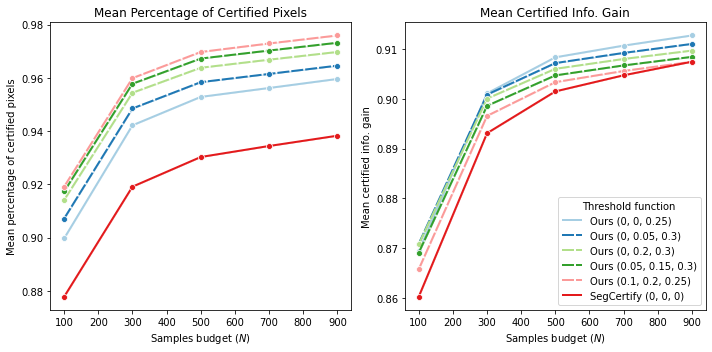

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
p = 'Paired'
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].set_title('Mean Percentage of Certified Pixels')
axes[1].set_title('Mean Certified Info. Gain')

# sns.displot(ax=axes[0], 
#             data=df_functions, 
#             x='Threshold function', 
#             y='Threshold value for which a pesterior should be $\geq$ to fall within $H_i$', 
#             hue='Heirarchy index',  
#             palette=p,)
#[axes[0].axvline(x+.5,color='k') for x in axes[0].get_xticks()]
sns.lineplot(data=df, x="Samples budget ($N$)", y='Mean percentage of certified pixels', ax=axes[0], legend=False,  
             hue="Threshold function", 
             marker='o',
             palette=p, size= "Threshold function", 
             sizes=[2]*(len(set(col_f))-1)+[2],
             style="Threshold function", dashes=[[3,0]]+[[6, 1]]*(len(set(col_f))-2)+[[3,0]])
sns.lineplot(data=df, x="Samples budget ($N$)", y="Mean certified info. gain",ax=axes[1],  
             hue="Threshold function", 
             marker='o',
             palette=p, size= "Threshold function", 
             sizes=[2]*(len(set(col_f))-1)+[2],
             style="Threshold function", dashes=[[3,0]]+[[6, 1]]*(len(set(col_f))-2)+[[3,0]])
# leg= axes[1].legend()
# for line in leg.get_lines()[:-1]:
#     line.set_linewidth(4.0)   
fig.tight_layout()
fig.savefig('graph_images/threshold.pgf')


In [98]:
sns.color_palette("rocket", 11)[0]

(0.12375803, 0.07174938, 0.18228425)